In [1]:
library(sf)
library(tmap)
library(tmaptools)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gstat)
library(sp)

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

Breaking News: tmap 3.x is retiring. Please test v4, e.g. with
remotes::install_github('r-tmap/tmap')


载入程序包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



载入程序包：‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Reading layer `nyct2020' from data source 
  `/Users/jiazhuangfeng/Documents/project/spatial_analysis/assignment/data/nyc2020_census/nyct2020.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2325 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 913175.1 ymin: 120128.4 xmax: 1067383 ymax: 272844.3
Projected CRS: NAD83 / New York Long Island (ftUS)


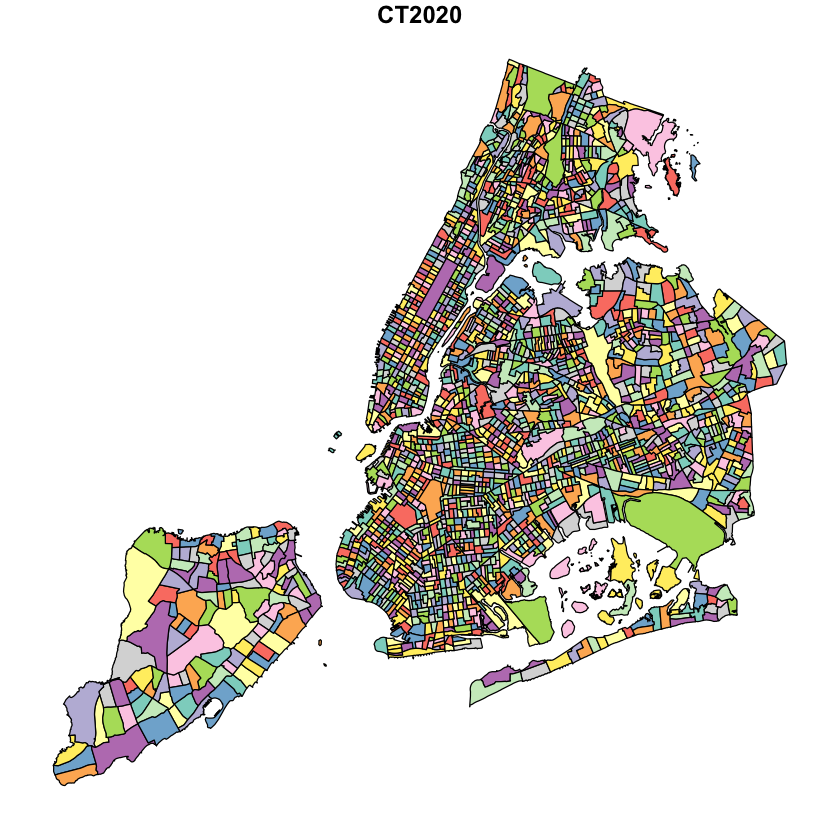

In [14]:
# Read the census shapefile
census <- st_read(dsn="./data/nyc2020_census/nyct2020.shp", layer="nyct2020")

# Load the population csv data
population <- read.csv("./data/nyc_censusdata_2020.csv")
population$BCT2020 <- as.character(population$BCT2020)

# Join population data to census data
census_joined <- census %>%
  left_join(population, by= c("BoroCT2020"="BCT2020"))

# Plot census polygons
plot(census_joined["CT2020"])

# Load Citibike data
citibike_oct_1 <- read.csv("./data/2019-citibike-tripdata/10_October/201910-citibike-tripdata_1.csv")
citibike_oct_2 <- read.csv("./data/2019-citibike-tripdata/10_October/201910-citibike-tripdata_2.csv")
citibike_oct_3 <- read.csv("./data/2019-citibike-tripdata/10_October/201910-citibike-tripdata_3.csv")

# Bind rows for October data
citibike_oct <- bind_rows(citibike_oct_1, citibike_oct_2, citibike_oct_3)

# Repeat for January data
citibike_jan <- read.csv("./data/2019-citibike-tripdata/1_January/201901-citibike-tripdata_1.csv")

# Load Citibike data
citibike_july_1 <- read.csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_1.csv")
citibike_july_2 <- read.csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_2.csv")
citibike_july_3 <- read.csv("./data/2019-citibike-tripdata/7_July/201907-citibike-tripdata_3.csv")

# Bind rows for October data
citibike_july <- bind_rows(citibike_july_1, citibike_july_2, citibike_july_3)

In [20]:
# 加载 janitor 包
library(janitor)

# 修改列名为 snake_case
citibike_jan <- citibike_jan %>% clean_names()
citibike_july <- citibike_july %>% clean_names()
citibike_oct <- citibike_oct %>% clean_names()

# 查看修改后的列名
print(colnames(citibike_july))


 [1] "tripduration"            "starttime"              
 [3] "stoptime"                "start_station_id"       
 [5] "start_station_name"      "start_station_latitude" 
 [7] "start_station_longitude" "end_station_id"         
 [9] "end_station_name"        "end_station_latitude"   
[11] "end_station_longitude"   "bikeid"                 
[13] "usertype"                "birth_year"             
[15] "gender"                 


In [22]:
# 统计 1 月份的 ride_activity 数据
station_jan <- citibike_jan %>%
  group_by(start_station_id, start_station_latitude, start_station_longitude) %>%
  summarise(ride_start_count = n(), .groups = "drop") %>%
  rename(station_id = start_station_id, station_lat = start_station_latitude, station_lng = start_station_longitude)

end_station_jan <- citibike_jan %>%
  group_by(end_station_id, end_station_latitude, end_station_longitude) %>%
  summarise(ride_end_count = n(), .groups = "drop") %>%
  rename(station_id = end_station_id, station_lat = end_station_latitude, station_lng = end_station_longitude)

# 分别统计起点和终点的骑行次数，并计算总的 ride_activity
station_jan <- station_jan %>%
  full_join(end_station_jan, by = c("station_id", "station_lat", "station_lng")) %>%
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count
  ) %>%
  select(station_id, station_lat, station_lng, ride_activity) # 仅保留所需列

# 统计 10 月份的 ride_activity 数据
station_oct <- citibike_oct %>%
  group_by(start_station_id, start_station_latitude, start_station_longitude) %>%
  summarise(ride_start_count = n(), .groups = "drop") %>%
  rename(station_id = start_station_id, station_lat = start_station_latitude, station_lng = start_station_longitude)

end_station_oct <- citibike_oct %>%
  group_by(end_station_id, end_station_latitude, end_station_longitude) %>%
  summarise(ride_end_count = n(), .groups = "drop") %>%
  rename(station_id = end_station_id, station_lat = end_station_latitude, station_lng = end_station_longitude)

# 分别统计起点和终点的骑行次数，并计算总的 ride_activity
station_oct <- station_oct %>%
  full_join(end_station_oct, by = c("station_id", "station_lat", "station_lng")) %>%
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count
  ) %>%
  select(station_id, station_lat, station_lng, ride_activity) # 仅保留所需列

# 统计 7 月份的 ride_activity 数据
station_july <- citibike_july %>%
  group_by(start_station_id, start_station_latitude, start_station_longitude) %>%
  summarise(ride_start_count = n(), .groups = "drop") %>%
  rename(station_id = start_station_id, station_lat = start_station_latitude, station_lng = start_station_longitude)

end_station_july <- citibike_july %>%
  group_by(end_station_id, end_station_latitude, end_station_longitude) %>%
  summarise(ride_end_count = n(), .groups = "drop") %>%
  rename(station_id = end_station_id, station_lat = end_station_latitude, station_lng = end_station_longitude)

# 分别统计起点和终点的骑行次数，并计算总的 ride_activity
station_july <- station_july %>%
  full_join(end_station_july, by = c("station_id", "station_lat", "station_lng")) %>%
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count
  ) %>%
  select(station_id, station_lat, station_lng, ride_activity) # 仅保留所需列

In [37]:
station_jan_sf <- station_jan %>%
  st_as_sf(coords = c("station_lng", "station_lat"), crs=4326, remove=FALSE)
station_july_sf <- station_july %>%
  st_as_sf(coords = c("station_lng", "station_lat"), crs=4326, remove=FALSE)
station_oct_sf <- station_oct %>%
  st_as_sf(coords = c("station_lng", "station_lat"), crs=4326, remove=FALSE)
station_jan_sf <- st_transform(station_jan_sf, st_crs(census_joined))
station_july_sf <- st_transform(station_july_sf, st_crs(census_joined))
station_oct_sf <- st_transform(station_oct_sf, st_crs(census_joined))

In [118]:
station_oct_sf

,station_id,station_lat,station_lng,ride_activity,geometry
,<int>,<dbl>,<dbl>,<dbl>,<POINT [US_survey_foot]>
1,72,40.76727,-73.99393,6939,POINT (985931.7 218814.8)
2,79,40.71912,-74.00667,5449,POINT (982402 201269.8)
3,82,40.71117,-74.00017,2910,POINT (984204.1 198376.4)
4,83,40.68383,-73.97632,4087,POINT (990816.7 188413.6)
5,116,40.74178,-74.00150,15560,POINT (983835 209525.6)
6,119,40.69609,-73.97803,1184,POINT (990341.1 192881.4)
7,120,40.68677,-73.95928,2161,POINT (995542.6 189487.1)
8,127,40.73172,-74.00674,13122,POINT (982380.8 205863.5)
9,128,40.72710,-74.00297,14414,POINT (983426.6 204179.6)


In [48]:
# Creating an aggregated station dataset at census tract level
station_oct_nyc <- station_oct_sf %>%
  # Left join to remove stations outside NYC (do not have census tract)
  st_join(census_joined, join= st_within, left=FALSE)
ct_station_oct <- station_oct_nyc %>%
  group_by(BoroCT2020) %>%
  summarise(
    num_stations = n(),
    total_ride_activity = sum(ride_activity, na.rm=TRUE),
      )

# Converting to df to allow for inner join and drop column for polygons without Citibike docks
ct_station_oct_df <- as.data.frame(ct_station_oct)
agg_citibike_oct <- census_joined %>%
  inner_join(ct_station_oct_df, by= "BoroCT2020")

In [42]:
# Creating an aggregated station dataset at census tract level
station_july_nyc <- station_july_sf %>%
  # Left join to remove stations outside NYC (do not have census tract)
  st_join(census_joined, join= st_within, left=FALSE)
ct_station_july <- station_july_nyc %>%
  group_by(BoroCT2020) %>%
  summarise(
    num_stations = n(),
    total_ride_activity = sum(ride_activity, na.rm=TRUE),
      )

# Converting to df to allow for inner join and drop column for polygons without Citibike docks
ct_station_july_df <- as.data.frame(ct_station_july)
agg_citibike_july <- census_joined %>%
  inner_join(ct_station_july_df, by= "BoroCT2020")

In [45]:
# Creating an aggregated station dataset at census tract level
station_jan_nyc <- station_jan_sf %>%
  # Left join to remove stations outside NYC (do not have census tract)
  st_join(census_joined, join= st_within, left=FALSE)
ct_station_jan <- station_jan_nyc %>%
  group_by(BoroCT2020) %>%
  summarise(
    num_stations = n(),
    total_ride_activity = sum(ride_activity, na.rm=TRUE),
      )

# Converting to df to allow for inner join and drop column for polygons without Citibike docks
ct_station_jan_df <- as.data.frame(ct_station_jan)
agg_citibike_jan <- census_joined %>%
  inner_join(ct_station_jan_df, by= "BoroCT2020")

In [49]:
library(tmap)

# 单个地图示例
map_jan <- tm_shape(census_joined) +
  tm_borders(col = "white") +
  tm_fill(col = "lightgrey") +
  tm_shape(agg_citibike_jan) +
  tm_polygons(col = "total_ride_activity",
              style = "quantile",
              palette = "YlOrRd",
              title = "Total Ride Start Count") +
  tm_layout(title = "Citibike Ride Activity (Jan 2019)",
            title.position = c("left", "top"),
            legend.position = c("left", "top"),
            legend.outside = FALSE,
            frame = FALSE)
# 七月地图
map_july <- tm_shape(census_joined) +
  tm_borders(col = "white") +
  tm_fill(col = "lightgrey") +
  tm_shape(agg_citibike_july) +
  tm_polygons(col = "total_ride_activity",
              style = "quantile",
              palette = "YlOrRd",
              title = "Total Ride Start Count") +
  tm_layout(title = "Citibike Ride Activity (July 2019)",
            title.position = c("left", "top"),
            legend.position = c("left", "top"),
            legend.outside = FALSE,
            frame = FALSE)

# 十月地图
map_oct <- tm_shape(census_joined) +
  tm_borders(col = "white") +
  tm_fill(col = "lightgrey") +
  tm_shape(agg_citibike_oct) +
  tm_polygons(col = "total_ride_activity",
              style = "quantile",
              palette = "YlOrRd",
              title = "Total Ride Start Count") +
  tm_layout(title = "Citibike Ride Activity (Oct 2019)",
            title.position = c("left", "top"),
            legend.position = c("left", "top"),
            legend.outside = FALSE,
            frame = FALSE)


Some legend labels were too wide. These labels have been resized to 0.63, 0.55, 0.55, 0.51. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.

Some legend labels were too wide. These labels have been resized to 0.55, 0.55, 0.51, 0.44. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.

Some legend labels were too wide. These labels have been resized to 0.55, 0.55, 0.51, 0.44. Increase legend.width (argument of tm_layout) to make the legend wider and therefore the labels larger.

Map saved to citibike_maps.png

Resolution: 3600 by 1200 pixels

Size: 12 by 4 inches (300 dpi)



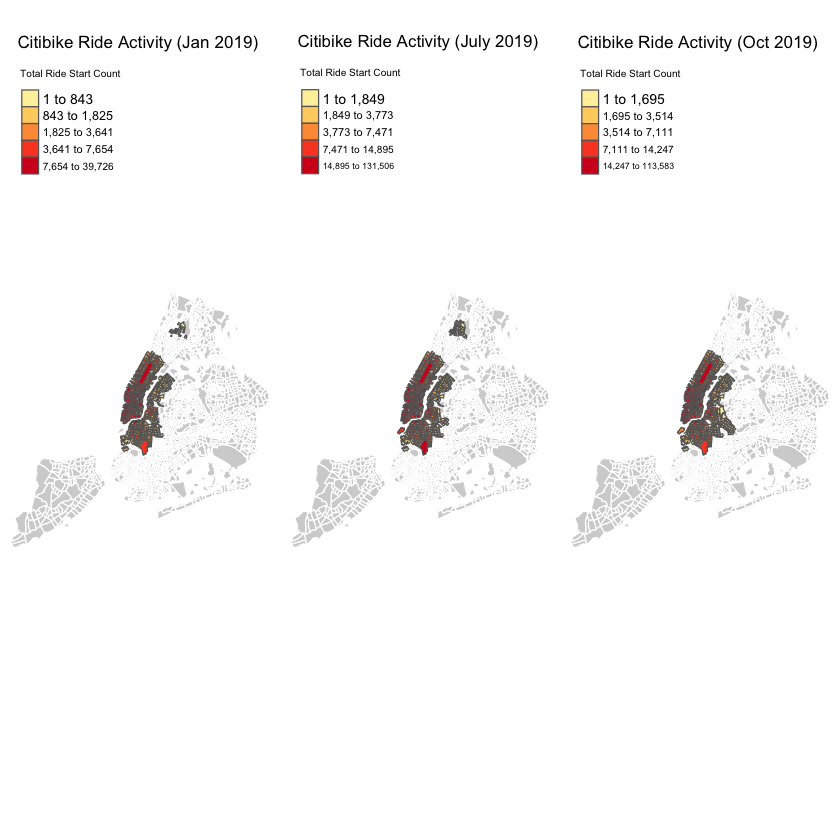

In [51]:
# 横向排列三个地图
tmap_arrange(map_jan, map_july, map_oct, ncol = 3)
tmap_save(tmap_arrange(map_jan, map_july, map_oct, ncol = 3), "citibike_maps.png", width = 12, height = 4)

In [60]:
library(spdep)  # 用于空间权重矩阵和空间统计
library(sf)     # 用于处理空间数据


载入需要的程序包：spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`



In [94]:
library(sf)
library(spdep)

# 定义函数
calculate_moran_poly2nb <- function(agg_sf, value_col) {
  # 检查输入
  if (!inherits(agg_sf, "sf")) {
    stop("Input data must be an sf object.")
  }
  if (!value_col %in% colnames(agg_sf)) {
    stop("The specified value column does not exist in the sf object.")
  }
  
  # 提取目标变量
  values <- agg_sf[[value_col]]
  
  # 1. 创建邻接列表（基于聚合后的多边形边界）
  nb <- poly2nb(agg_sf)
  
  # 2. 转换为权重矩阵（矩阵形式）
  W <- nb2mat(nb, style = "W", zero.policy = TRUE)
  colnames(W) <- rownames(W) <- row.names(agg_sf)
  
  # 3. 转换为权重列表（listw 格式，用于 Moran's I 计算）
  Wl <- nb2listw(nb, style = "W", zero.policy = TRUE)
  
  # 4. 计算 Moran's I
  moran_result <- moran.test(values, Wl, zero.policy = TRUE)
  
  # 输出结果
  cat("Moran's I:", moran_result$estimate["Moran I"], "\n")
  cat("Expected I:", moran_result$estimate["Expectation"], "\n")
  cat("Variance:", moran_result$estimate["Variance"], "\n")
  cat("p-value:", moran_result$p.value, "\n")
  
  # 返回结果
  return(list(
    W_matrix = W,
    W_listw = Wl,
    moran_test = moran_result
  ))
}


In [114]:
result_jan <- calculate_moran_poly2nb(agg_citibike_jan, value_col = "total_ride_activity")


# 查看 Moran's I 统计结果
print(result_jan$moran_test)

result_july <- calculate_moran_poly2nb(agg_citibike_july, value_col = "total_ride_activity")


# 查看 Moran's I 统计结果
print(result_july$moran_test)

result_oct <- calculate_moran_poly2nb(agg_citibike_oct, value_col = "total_ride_activity")


# 查看 Moran's I 统计结果
print(result_oct$moran_test)


Warning message in poly2nb(agg_sf):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf):
“neighbour object has 6 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”


Moran's I: NA 
Expected I: -0.00243309 
Variance: 0.001010017 
p-value: 3.396938e-51 

	Moran I test under randomisation

data:  values  
weights: Wl  
n reduced by no-neighbour observations  

Moran I statistic standard deviate = 15.005, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.474442019      -0.002433090       0.001010017 



Warning message in poly2nb(agg_sf):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf):
“neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”


Moran's I: NA 
Expected I: -0.002277904 
Variance: 0.0009151393 
p-value: 9.171286e-50 

	Moran I test under randomisation

data:  values  
weights: Wl  
n reduced by no-neighbour observations  

Moran I statistic standard deviate = 14.785, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.4449830210     -0.0022779043      0.0009151393 



Warning message in poly2nb(agg_sf):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf):
“neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”


Moran's I: NA 
Expected I: -0.002309469 
Variance: 0.0009052925 
p-value: 1.066471e-57 

	Moran I test under randomisation

data:  values  
weights: Wl  
n reduced by no-neighbour observations  

Moran I statistic standard deviate = 15.968, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.4781389814     -0.0023094688      0.0009052925 



In [105]:
library(sf)
library(spdep)

# 定义函数
calculate_local_moran <- function(agg_sf, value_col, snap = 0) {
  # 检查输入
  if (!inherits(agg_sf, "sf")) {
    stop("Input data must be an sf object.")
  }
  if (!value_col %in% colnames(agg_sf)) {
    stop("The specified value column does not exist in the sf object.")
  }
  
  # 提取目标变量
  values <- agg_sf[[value_col]]
  
  # 1. 创建邻接列表（基于多边形边界，增加 snap 参数）
  nb <- poly2nb(agg_sf, snap = snap)
  
  # 检查是否有孤立单元
  if (any(card(nb) == 0)) {
    warning("Some observations have no neighbours. These will be excluded from the analysis.")
  }
  
  # 2. 转换为权重列表（listw 格式，用于 Moran's I 计算）
  Wl <- nb2listw(nb, style = "W", zero.policy = TRUE)
  
  # 3. 计算局部 Moran's I
  local_moran_result <- localmoran(values, Wl, zero.policy = TRUE)
  
  # 打印列名，供调试使用
  cat("Local Moran's I result columns:", colnames(local_moran_result), "\n")
  
  # 4. 将结果添加到 sf 对象中
  agg_sf$local_moran_I <- local_moran_result[, "Ii"]                 # 局部 Moran's I 值
  agg_sf$local_moran_p <- local_moran_result[, "Pr(z != E(Ii))"]     # 双尾 p 值
  
  # 输出结果
  cat("Local Moran's I 已计算完成，并添加到 sf 对象中。\n")
  
  # 返回结果
  return(list(
    agg_sf = agg_sf,
    local_moran_result = local_moran_result
  ))
}


Warning message in poly2nb(agg_sf):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf):
“neighbour object has 6 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”


Moran's I: NA 
Expected I: -0.00243309 
Variance: 0.001010017 
p-value: 3.396938e-51 

	Moran I test under randomisation

data:  values  
weights: Wl  
n reduced by no-neighbour observations  

Moran I statistic standard deviate = 15.005, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.474442019      -0.002433090       0.001010017 



In [108]:
result_jan <- calculate_local_moran(agg_citibike_jan, value_col = "total_ride_activity")

# 提取更新后的 sf 对象
agg_citibike_jan_with_moran <- result_jan$agg_sf


result_july <- calculate_local_moran(agg_citibike_july, value_col = "total_ride_activity")

# 提取更新后的 sf 对象
agg_citibike_july_with_moran <- result_july$agg_sf


result_oct <- calculate_local_moran(agg_citibike_oct, value_col = "total_ride_activity")

# 提取更新后的 sf 对象
agg_citibike_oct_with_moran <- result_oct$agg_sf



Warning message in poly2nb(agg_sf, snap = snap):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf, snap = snap):
“neighbour object has 7 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”
Warning message in calculate_local_moran(agg_citibike_jan, value_col = "total_ride_activity"):
“Some observations have no neighbours. These will be excluded from the analysis.”


Local Moran's I result columns: Ii E.Ii Var.Ii Z.Ii Pr(z != E(Ii)) 
Local Moran's I 已计算完成，并添加到 sf 对象中。


Warning message in poly2nb(agg_sf, snap = snap):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf, snap = snap):
“neighbour object has 4 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”
Warning message in calculate_local_moran(agg_citibike_july, value_col = "total_ride_activity"):
“Some observations have no neighbours. These will be excluded from the analysis.”


Local Moran's I result columns: Ii E.Ii Var.Ii Z.Ii Pr(z != E(Ii)) 
Local Moran's I 已计算完成，并添加到 sf 对象中。


Warning message in poly2nb(agg_sf, snap = snap):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf, snap = snap):
“neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”
Warning message in calculate_local_moran(agg_citibike_oct, value_col = "total_ride_activity"):
“Some observations have no neighbours. These will be excluded from the analysis.”


Local Moran's I result columns: Ii E.Ii Var.Ii Z.Ii Pr(z != E(Ii)) 
Local Moran's I 已计算完成，并添加到 sf 对象中。


In [115]:
library(tmap)

# 创建每个月的局部 Moran's I 地图
map_jan <- tm_shape(agg_citibike_jan_with_moran) +
  tm_polygons(
    col = "local_moran_I",
    palette = "-RdBu",
    style = "quantile",
    title = "Local Moran's I (Jan)"
  ) +
  tm_layout(
    main.title.size = 1.2
  )

map_july <- tm_shape(agg_citibike_july_with_moran) +
  tm_polygons(
    col = "local_moran_I",
    palette = "-RdBu",
    style = "quantile",
    title = "Local Moran's I (July)"
  ) +
  tm_layout(
    main.title.size = 1.2
  )

map_oct <- tm_shape(agg_citibike_oct_with_moran) +
  tm_polygons(
    col = "local_moran_I",
    palette = "-RdBu",
    style = "quantile",
    title = "Local Moran's I (Oct)"
  ) +
  tm_layout(
    main.title.size = 1.2
  )

# 将三个地图横向排布
combined_map <- tmap_arrange(map_jan, map_july, map_oct, ncol = 3)

# 保存为 PNG 文件
tmap_save(combined_map, filename = "local_moran_comparison.png", width = 12, height = 4, units = "in", dpi = 300)


Variable(s) "local_moran_I" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Variable(s) "local_moran_I" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Variable(s) "local_moran_I" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

Map saved to /Users/jiazhuangfeng/Documents/project/spatial_analysis/assignment/local_moran_comparison.png

Resolution: 3600 by 1200 pixels

Size: 12 by 4 inches (300 dpi)



In [113]:
library(spdep)  # 用于空间权重矩阵和 Moran's I 计算

# 创建邻接列表和权重矩阵的函数
create_weights <- function(agg_sf, snap = 0.01) {
  # 1. 创建邻接列表
  nb <- poly2nb(agg_sf, snap = snap)
  
  # 检查是否有孤立单元
  if (any(card(nb) == 0)) {
    warning("Some observations have no neighbours. These will be excluded from the analysis.")
  }
  
  # 2. 转换为权重列表
  Wl <- nb2listw(nb, style = "W", zero.policy = TRUE)
  return(Wl)
}

# 为每个月创建权重矩阵
Wl_jan <- create_weights(agg_citibike_jan_with_moran)
Wl_july <- create_weights(agg_citibike_july_with_moran)
Wl_oct <- create_weights(agg_citibike_oct_with_moran)

# Moran 散点图绘制函数
plot_moran <- function(data, Wl, value_col, title) {
  moran.plot(
    data[[value_col]],
    Wl,
    xlab = "Total Ride Start Count",
    ylab = "Spatially Lagged Ride Start Count",
    labels = data$NTAName,  # 替换为区域名称列
    main = title
  )
}

# 保存为 PNG 文件
png("moran_scatterplots.png", width = 1200, height = 800)

# 设置图形布局：1 行 3 列
par(mfrow = c(1, 3))  # 1 行 3 列布局

# 绘制 1 月散点图
plot_moran(
  agg_citibike_jan_with_moran,
  Wl_jan,
  value_col = "total_ride_activity",
  title = "Moran Scatterplot (January)"
)

# 绘制 7 月散点图
plot_moran(
  agg_citibike_july_with_moran,
  Wl_july,
  value_col = "total_ride_activity",
  title = "Moran Scatterplot (July)"
)

# 绘制 10 月散点图
plot_moran(
  agg_citibike_oct_with_moran,
  Wl_oct,
  value_col = "total_ride_activity",
  title = "Moran Scatterplot (October)"
)

# 关闭图形设备
dev.off()


Warning message in poly2nb(agg_sf, snap = snap):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf, snap = snap):
“neighbour object has 6 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”
Warning message in create_weights(agg_citibike_jan_with_moran):
“Some observations have no neighbours. These will be excluded from the analysis.”
Warning message in poly2nb(agg_sf, snap = snap):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_sf, snap = snap):
“neighbour object has 3 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”
Warning message in create_weights(agg_citibike_july_with_moran):
“Some observations have no neighbours. These will be excluded from the analysis.”
Warning message in poly2nb(agg_sf, snap = snap):
“some observations have no neighbour

pdf 
  2